In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, Dense,
    Dropout, Concatenate, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score,
    recall_score, f1_score, cohen_kappa_score
)

import seaborn as sns


In [2]:
tf.config.set_visible_devices([], 'GPU')
TRAIN_DIR = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/train"
TEST_DIR  = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test"


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
CLASS_NAMES = list(train_gen.class_indices.keys())

Found 8684 images belonging to 10 classes.
Found 2170 images belonging to 10 classes.
Found 1497 images belonging to 10 classes.


In [7]:
input_layer = Input(shape=(224,224,3))

mobilenet = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=input_layer
)
mobilenet.trainable = False

m = GlobalAveragePooling2D()(mobilenet.output)
m = BatchNormalization()(m)

c = Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
c = MaxPooling2D(2)(c)

c = Conv2D(64, (3,3), activation="relu", padding="same")(c)
c = MaxPooling2D(2)(c)

c = Conv2D(128, (3,3), activation="relu", padding="same")(c)
c = GlobalAveragePooling2D()(c)

fusion = Concatenate()([m, c])

x = Dense(256, activation="relu")(fusion)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output)


/tmp/ipython-input-1850777833.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,751,242 (10.50 MB)

 Trainable params: 490,698 (1.87 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [9]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 4718s 9s/step - accuracy: 0.4490 - loss: 1.8212 - val_accuracy: 0.7751 - val_loss: 1.0404 - learning_rate: 1.0000e-04
Epoch 2/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1575s 3s/step - accuracy: 0.7423 - loss: 1.1306 - val_accuracy: 0.8378 - val_loss: 0.9103 - learning_rate: 1.0000e-04
Epoch 3/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1581s 3s/step - accuracy: 0.8010 - loss: 1.0137 - val_accuracy: 0.8770 - val_loss: 0.8471 - learning_rate: 1.0000e-04
Epoch 4/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1568s 3s/step - accuracy: 0.8247 - loss: 0.9469 - val_accuracy: 0.8968 - val_loss: 0.8131 - learning_rate: 1.0000e-04
Epoch 5/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1567s 3s/step - accuracy: 0.8515 - loss: 0.9063 - val_accuracy: 0.9060 - val_loss: 0.7853 - learning_rate: 1.0000e-04
Epoch 6/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1573s 3s/step - accuracy: 0.8538 - loss: 0.8867 - val_accuracy: 0.9101 - val_loss: 0.7732 - learning_rate: 1.0000e-04
Epoch 7/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1565s 3s/ste

In [12]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9610 - loss: 0.6603
Test Accuracy: 0.9726119041442871


In [14]:
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall    = recall_score(y_true, y_pred, average="weighted")
f1        = f1_score(y_true, y_pred, average="weighted")
kappa     = cohen_kappa_score(y_true, y_pred)

print("\n=== MODEL PERFORMANCE ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("Kappa    :", kappa)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


94/94 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step

=== MODEL PERFORMANCE ===
Accuracy : 0.9726118904475618
Precision: 0.9732274370026729
Recall   : 0.9726118904475618
F1-score : 0.9725656069670046
Kappa    : 0.9695685695090721

Classification Report:

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.99      1.00       150
           brown_spot       0.93      0.94      0.93       150
              healthy       0.99      0.90      0.94       149
           leaf_blast       0.93      0.94      0.94       150
           leaf_scald       0.98      0.99      0.99       149
    narrow_brown_spot       0.99      0.98      0.98       150
           neck_blast       1.00      1.00      1.00       149
           rice_hispa       0.93      1.00      0.96       150
        sheath_blight       0.99      0.98      0.99       150
               tungro       1.00      1.00      1.00       150

             accuracy                           0.97      1497


In [51]:
MODEL_PATH = "/content/drive/MyDrive/Rice/mobilenet_fusion_model.keras"
model.save(MODEL_PATH)
print("Model saved successfully in .keras format!")


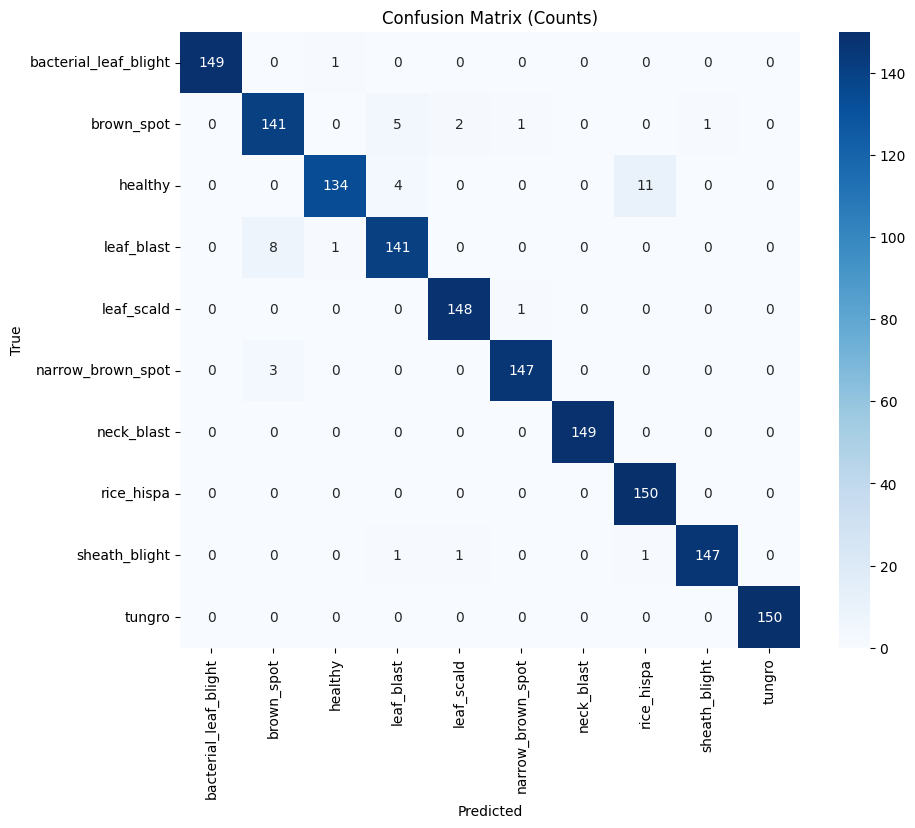

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Counts)")
plt.show()


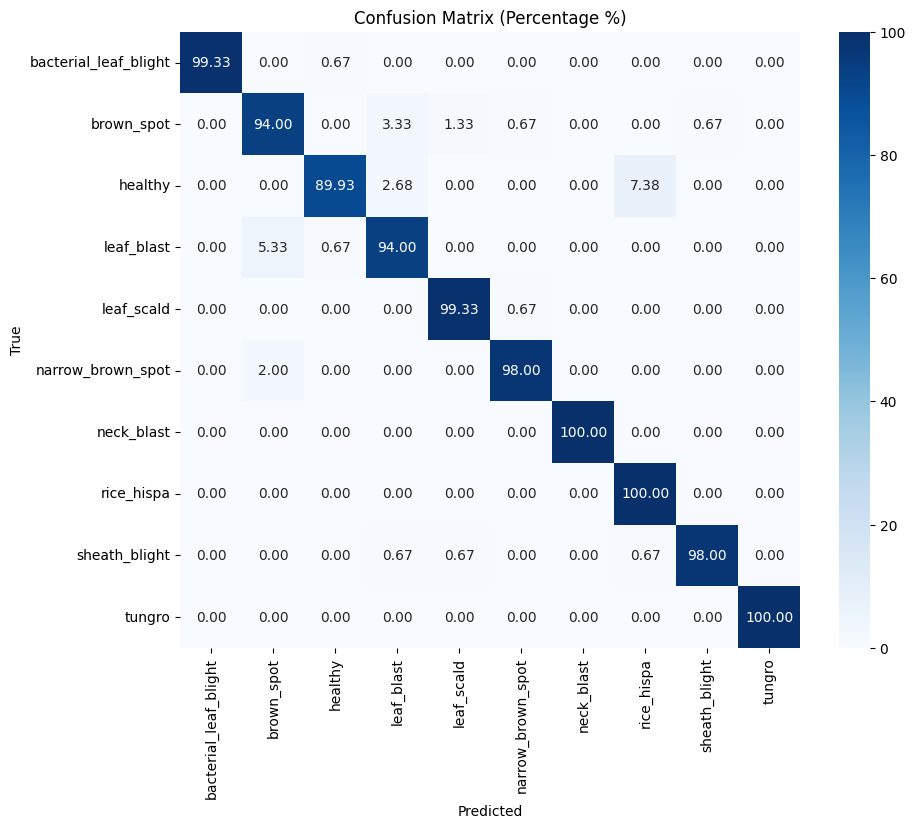

In [20]:
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10,8))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Percentage %)")
plt.show()


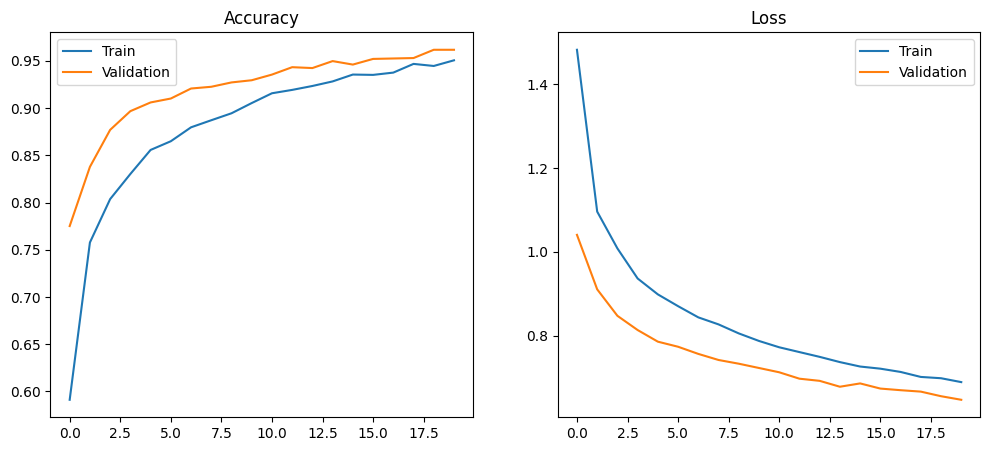

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


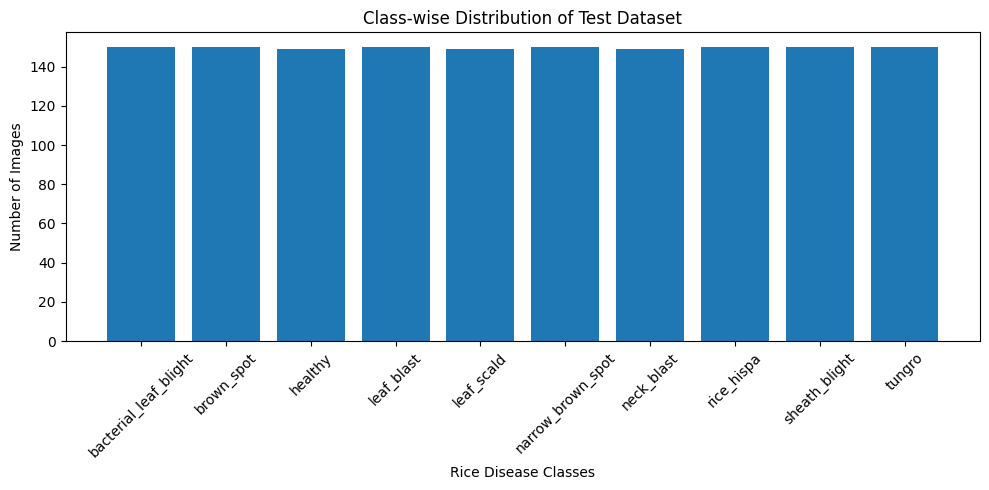

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class_names = list(test_gen.class_indices.keys())
class_counts = pd.Series(test_gen.classes).value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(class_names, class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Rice Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class-wise Distribution of Test Dataset")
plt.tight_layout()
plt.show()

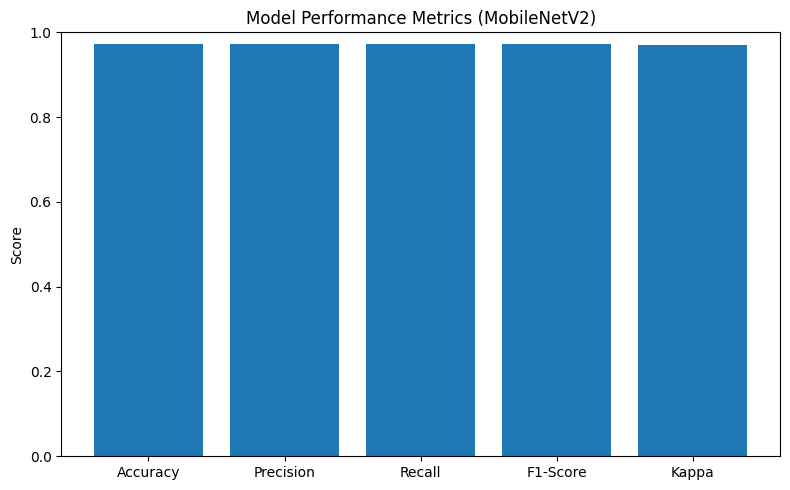

In [23]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred)
metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score", "Kappa"]
metrics_values = [accuracy, precision, recall, f1, kappa]

plt.figure(figsize=(8,5))
plt.bar(metrics_names, metrics_values)
plt.ylim(0,1)
plt.title("Model Performance Metrics (MobileNetV2)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


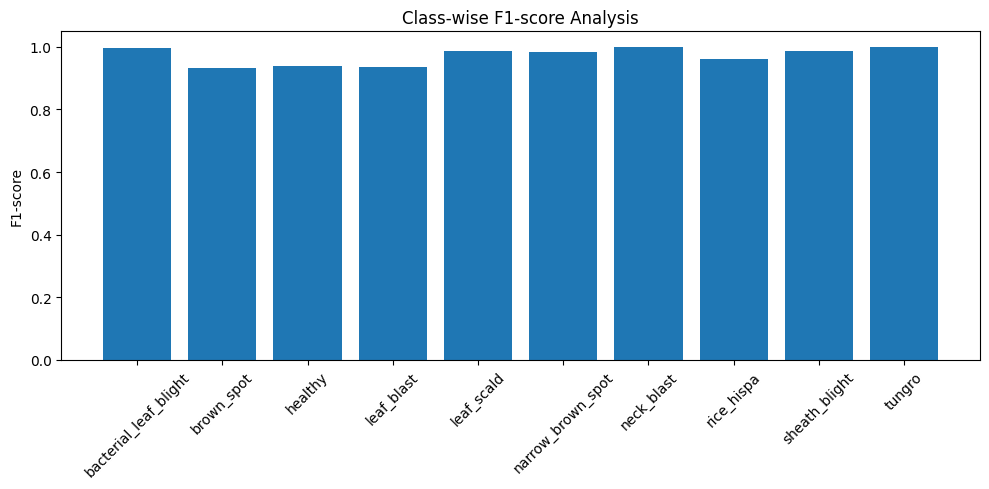

In [24]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)

f1_scores = [report[c]["f1-score"] for c in class_names]

plt.figure(figsize=(10,5))
plt.bar(class_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel("F1-score")
plt.title("Class-wise F1-score Analysis")
plt.tight_layout()
plt.show()


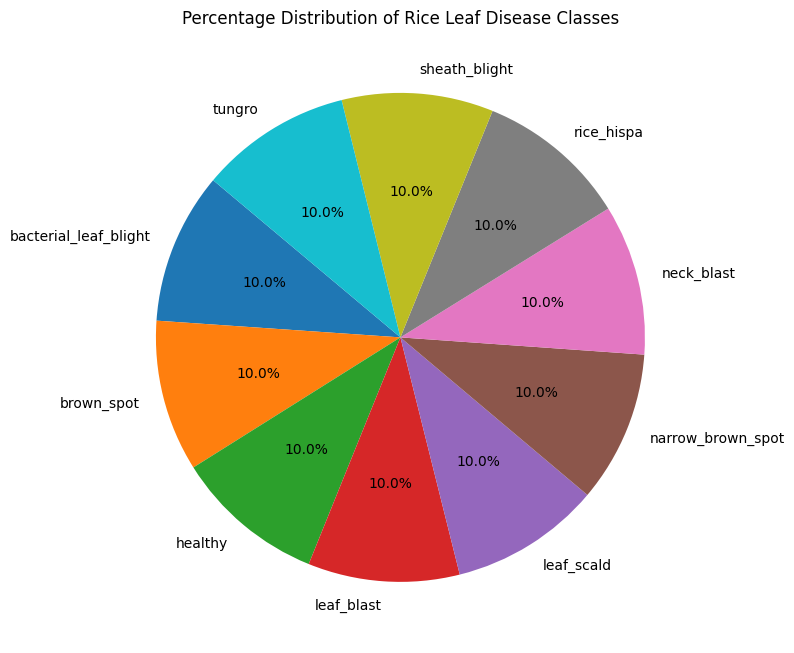

In [25]:
plt.figure(figsize=(8,8))
plt.pie(
    class_counts.values,
    labels=class_names,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Percentage Distribution of Rice Leaf Disease Classes")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

Predicted Class: rice_hispa
Class Probabilities:
bacterial_leaf_blight: 0.05%
brown_spot: 0.05%
healthy: 0.08%
leaf_blast: 0.01%
leaf_scald: 0.02%
narrow_brown_spot: 0.16%
neck_blast: 0.09%
rice_hispa: 99.42%
sheath_blight: 0.02%
tungro: 0.11%
Using last conv layer: conv2d_2


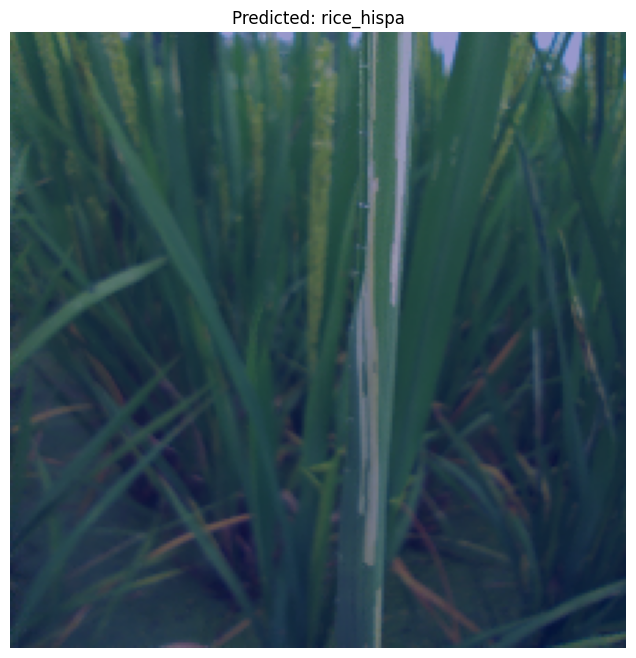

In [49]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_and_explain(model, class_names, img_path, IMG_SIZE=(224,224)):

    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_index = np.argmax(preds[0])
    predicted_class = class_names[class_index]

    print(f"\nPredicted Class: {predicted_class}")
    print("Class Probabilities:")
    for i, name in enumerate(class_names):
        print(f"{name}: {preds[0][i]*100:.2f}%")

    last_conv_layer_name = next(
        (layer.name for layer in reversed(model.layers) if isinstance(layer, tf.keras.layers.Conv2D)),
        None
    )
    print(f"Using last conv layer: {last_conv_layer_name}")

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = cv2.resize(heatmap.numpy(), IMG_SIZE)

    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, IMG_SIZE)

    heatmap_color = heatmap_color.astype(np.uint8)
    img_orig = img_orig.astype(np.uint8)

    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

user_input_path = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test/rice_hispa/Rice_Hispa (126).jpg"
predict_and_explain(model, CLASS_NAMES, user_input_path, IMG_SIZE)


In [52]:
import pickle

with open("/content/drive/MyDrive/Rice/class_names.pkl", "wb") as f:
    pickle.dump(CLASS_NAMES, f)